# Qwen3 Tuning
for ARC AGI 2

Updates 29 July 2025:
- Now using utils from the repo.
- Updated lora r to 128, down from 256 as prob 128 is sufficient.

Updates 24 July 2025:
- Now supports calculation of metrics BUT requires validation data have code. This will be updated later to just pass grids for validation.

Updates 23 July 2025:
- Back to constant scheduler for one epoch. Note that SOAR use 3 epochs with cosine scheduler.

Updates 22 July 2025:
- Increased lora r to 256
- Added training on completions only
- Moved to cosine rather than constant scheduler. Moved from 1 to 2 epochs. Note that SOAR use 3 epochs with cosine scheduler.

In [1]:
!git pull

Already up to date.


### Installation

In [2]:
# Temporary Fix while unsloth is broken!
!rm -rf /tmp/unsloth_compiled_cache
!uv pip uninstall trl unsloth --system
!uv pip install unsloth -qU --system
!uv pip install trl==0.19.1 --system

Using Python 3.11.11 environment at: /usr
Uninstalled 2 packages in 16ms
 - trl==0.19.1
 - unsloth==2025.7.11
Using Python 3.11.11 environment at: /usr
Resolved 61 packages in 40ms                                         
Uninstalled 1 package in 4ms
Installed 1 package in 10ms                                 
 - trl==0.20.0
 + trl==0.19.1


In [3]:
# INSTALLED IN THE CONTAINER IF USING the [arc-agi-2025 container on runpod](https://console.runpod.io/deploy?template=bh0rvngapk&ref=jmfkcdio)
# %%capture
# import os
# !pip install uv -qU
# !uv pip install unsloth matplotlib tensorboard -qU --system
# !export HF_HUB_ENABLE_HF_TRANSFER=1

In [4]:
from huggingface_hub import HfFolder, login

# Call this at the top of your script / notebook
if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
    login()                        # interactive prompt

In [5]:
%load_ext tensorboard
%tensorboard --logdir ./logs --port 6006 --bind_all

### Unsloth

In [6]:
import unsloth
from unsloth import FastLanguageModel
import torch, os

model_slug = "Qwen/Qwen3-4B"
# model_slug = "julien31/Soar-qwen-7b"
# model_slug = "Qwen/Qwen2.5-Coder-7B-Instruct"
# model_slug = "Qwen/Qwen3-30B-A3B"

model_max_length = 32768 #default is ~2k for unsloth!!!

# Training AND validation batch size (incl. for autoregressive train/test example metrics calculations)
batch_size_global=8 # use 2 for 7/8B, use 8 for 4B

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = model_max_length,   # Context length - can be longer, but uses more memory
    load_in_4bit = False,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    cache_dir = '',
    # token = "hf_...",      # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.11: Fast Qwen3 patching. Transformers: 4.54.0.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.189 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
print(model.max_seq_length)

32768


In [8]:
# # Print a summary of the transformer layers and key dimensions
# for i, block in enumerate(model.model.layers):
#     attn = block.self_attn
#     mlp = block.mlp

#     print(f"Layer {i}:")
#     print(f"  Attention:")
#     print(f"    q_proj: {attn.q_proj.weight.shape}")
#     print(f"    k_proj: {attn.k_proj.weight.shape}")
#     print(f"    v_proj: {attn.v_proj.weight.shape}")
#     print(f"    out_proj: {attn.o_proj.weight.shape}")
#     print(f"  MLP:")
#     print(f"    fc1: {mlp.gate_proj.weight.shape}")
#     print(f"    fc2: {mlp.up_proj.weight.shape}")
#     print(f"    fc3: {mlp.down_proj.weight.shape}")
#     print()

In [9]:
# print(model)

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [10]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 128,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128. could consider 128.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",
                     ],
    lora_alpha = 64,  # Best to choose alpha = rank or rank*2. EXCEPT if using rslora, in which case set it as sqrt(max matrix dimension). 64 is good for Qwen 4B
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.7.11 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [11]:
# Import utils using standard project root detection
from pathlib import Path
import sys

# Find project root by looking for pyproject.toml
project_root = next(
    (parent for parent in [Path.cwd()] + list(Path.cwd().parents) 
     if (parent / "pyproject.toml").exists()), 
    Path.cwd()
)

# Add llm-python directory to path (where utils is located)
llm_python_dir = project_root / "llm-python"
sys.path.insert(0, str(llm_python_dir))

print(f"📁 Project root: {project_root}")
print(f"📁 Looking for utils in: {llm_python_dir}")

from utils.task_loader import TaskLoader
from utils.scoring import GridScorer, ProgramExecutor
from utils.prompt_utils import create_arc_prompt, extract_python_code
from utils.metrics_utils import calculate_task_metrics, format_metrics_display, metrics_to_percentages
from utils.timeout_utils import execute_with_timeout
from utils.transduction import is_transduction_cheating
from utils.prompt_loader import PromptLoader

# Initialize utility instances
prompt_loader = PromptLoader()
scorer = GridScorer()
print("✅ Utils imported and initialized successfully")

📁 Project root: /workspace/arc-agi-2025
📁 Looking for utils in: /workspace/arc-agi-2025/llm-python
✅ Utils imported and initialized successfully


<a name="Data"></a>
### Data Prep

In [12]:
from pathlib import Path
import json
from typing import Optional
from datasets import load_dataset, DatasetDict

# ---------------------------------------------------------------------
# Config (examples)
# ---------------------------------------------------------------------

# Set max_rows flag to limit train size. None for all
max_rows = 32
max_validation_rows = 8

# # CASE 1: single slug with both splits
# train_slug = "Trelis/synth_arc-agi-1_all_training_20250724_131808"
# val_slug = None

# CASE 2: two different slugs
train_slug = "Trelis/soar-20250729_114431-1600"
val_slug   = "Trelis/grids_only_arc-agi-1_all_evaluation_20250729_102313"

enable_thinking = False  # See note in original code

# ---------------------------------------------------------------------
# Prompt management using utils (replacing hard-coded prompts)
# ---------------------------------------------------------------------

# Use prompt_loader to get SOAR prompts from utils
SYSTEM_PROMPT = prompt_loader.get_system_message("soar")
INITIAL_TURN_PROMPT = prompt_loader.get_initial_turn_prompt("soar")

print(f"✅ Using SOAR prompts from utils:")
print(f"   System prompt: {len(SYSTEM_PROMPT)} chars")
print(f"   Initial turn prompt: {len(INITIAL_TURN_PROMPT)} chars")

# Custom formatting functions removed - using create_arc_prompt from utils instead

def hf_dataset_to_chat_dataset(dataset_slug: str, split: str = "train"):
    """
    Convert a HF split into the chat/prompt format using utils.
    """
    ds = load_dataset(dataset_slug, split=split, keep_in_memory=True)

    def create_chat_messages(example):
        # Create task_data in the format expected by create_arc_prompt
        task_data = {
            'train': [{'input': inp, 'output': out} 
                     for inp, out in zip(example["train_input"], example["train_output"])],
            'test': [{'input': inp, 'output': out} 
                     for inp, out in zip(example["test_input"], example["test_output"])]  # All test examples!
        }
        
        # Use create_arc_prompt from utils (matches run_arc_tasks_soar.py)
        system_content, user_content = create_arc_prompt(task_data, prompt_loader, "soar")

        assistant_content = ""
        if enable_thinking and example.get("reasoning", "").strip():
            assistant_content += f"<think>{example['reasoning'].strip()}</think>"
        assistant_content += f"```python\n{example['code']}\n```"

        messages = [
            {"role": "system", "content": system_content},
            {"role": "user",   "content": user_content},
            {"role": "assistant", "content": assistant_content},
        ]

        prompt_messages = [
            {"role": "system", "content": system_content},
            {"role": "user",   "content": user_content},
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False,
            enable_thinking = enable_thinking
        )

        prompt_text = tokenizer.apply_chat_template(
            prompt_messages,
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking = enable_thinking
        )

        return {
            "messages": messages,
            "text": text,
            "prompt": prompt_text,
            "train_input": example["train_input"],
            "train_output": example["train_output"],
            "test_input": example["test_input"],
            "test_output": example["test_output"],
            "reasoning": example.get("reasoning", ""),
            "code": example["code"],
            "task_id": example.get("task_id", ""),
        }

    ds = ds.map(create_chat_messages, desc=f"build chat + prompt fields ({split})")
    return ds

def build_dataset(train_slug: str,
                  val_slug: Optional[str] = None,
                  train_split: str = "train",
                  val_split: str = "validation") -> DatasetDict:
    """
    Build a DatasetDict with 'train' and 'validation' keys.
    - If val_slug is None, both splits are loaded from train_slug.
    - Otherwise, load train_split from train_slug and val_split from val_slug.
    """
    
    # Load and filter
    train_ds = hf_dataset_to_chat_dataset(train_slug, split=train_split)
    if max_rows:
        train_ds = train_ds.select(range(min(len(train_ds), max_rows)))
    
    # Validation logic
    if val_slug is None:
        try:
            val_ds = hf_dataset_to_chat_dataset(train_slug, split=val_split)
        except Exception as e:
            raise ValueError(
                f"Could not load split '{val_split}' from '{train_slug}'. "
                f"Pass an explicit val_slug or choose a valid split.\nOriginal error: {e}"
            )
    else:
        val_ds = hf_dataset_to_chat_dataset(val_slug, split="train")
    
    # Corrected slice
    if max_validation_rows:
        val_ds = val_ds.select(range(min(len(val_ds), max_validation_rows)))
    elif max_rows:
        val_ds = val_ds.select(range(min(len(val_ds), max_rows)))
    
    return DatasetDict(train=train_ds, validation=val_ds)

# ---------------------------------------------------------------------
# Build the dataset
# ---------------------------------------------------------------------
data = build_dataset(train_slug, val_slug)  # val_slug may be None 

✅ Using SOAR prompts from utils:
   System prompt: 129 chars
   Initial turn prompt: 990 chars


build chat + prompt fields (train):   0%|          | 0/1600 [00:00<?, ? examples/s]

build chat + prompt fields (train):   0%|          | 0/400 [00:00<?, ? examples/s]

In [13]:
# Validation split
val_ids = [ex["task_id"] for ex in data["validation"]]
assert all(val_ids), "❌ some validation rows are missing task_id"
assert len(val_ids) == len(set(val_ids)), "❌ duplicate task_id in validation slice"

In [14]:
# print(data["train"][0])
print(data["train"][0]['prompt'])

<|im_start|>system
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>
<|im_start|>user
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.
Your goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.
You should only write the implemented the transformation in code.
You must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').
You should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs).
The number in the input grid can be mapped to the following

In [15]:
print(data["train"][0]['text'])

<|im_start|>system
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>
<|im_start|>user
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.
Your goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.
You should only write the implemented the transformation in code.
You must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').
You should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs).
The number in the input grid can be mapped to the following

In [16]:
print(data["validation"][0]['text'])

<|im_start|>system
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>
<|im_start|>user
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.
Your goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.
You should only write the implemented the transformation in code.
You must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').
You should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs).
The number in the input grid can be mapped to the following

Let's see the structure of both datasets:

In [17]:
import numpy as np
from statistics import median

def length_stats(dataset, name=""):
    """
    Return min / median / max tokenised length for a 🤗 Dataset split that has a
    single 'text' column. Uses the same tokenizer already in memory.
    """
    # Tokenise in batches → list of list[int] → list[int] lengths
    lengths = dataset.map(
        lambda batch: {
            "len": [len(ids) for ids in tokenizer(batch["text"],
                                                  add_special_tokens=False
                                                 )["input_ids"]]
        },
        batched=True,
        remove_columns=dataset.column_names,   # drop 'text'
        keep_in_memory=True,
    )["len"]

    print(f"{name:>11}:  min={min(lengths):>4}  "
          f"median={int(median(lengths)):>4}  max={max(lengths):>4}")

# ── run for both splits ────────────────────────────────────────────────────────
length_stats(data["train"],       "train")
length_stats(data["validation"],  "validation")


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

      train:  min= 735  median=1764  max=6472


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

 validation:  min= 631  median=4789  max=15051


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer).

In [18]:
from datetime import datetime
import re

# Extract date and time using regex
print("Extract training set date and time as dataset identifiers")

# Try pattern 1: timestamp at end (original pattern)
match = re.search(r'(\d{8}_\d{6})$', train_slug)
if match:
    timestamp = match.group(1)
    date_str = timestamp[:8]
    time_str = timestamp[9:]
    print(f"Date: {date_str} (YYYYMMDD)")
    print(f"Time: {time_str} (HHMMSS)")
else:
    # Try pattern 2: SOAR dataset format (soar-YYYYMMDD_HHMMSS-rows)
    match = re.search(r'soar-(\d{8}_\d{6})-\d+', train_slug)
    if match:
        timestamp = match.group(1)
        date_str = timestamp[:8]
        time_str = timestamp[9:]
        print(f"Date: {date_str} (YYYYMMDD)")
        print(f"Time: {time_str} (HHMMSS)")
    else:
        print("No timestamp found.")
        date_str = "unknown"
        time_str = "unknown"

run_name = f"{model_slug.split('/')[-1]}-ds{date_str}_{time_str}-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
print(f"Run name will be {run_name}")

Extract training set date and time as dataset identifiers
Date: 20250729 (YYYYMMDD)
Time: 114431 (HHMMSS)
Run name will be Qwen3-4B-ds20250729_114431-20250729-130517


In [19]:
import re, copy, traceback, numpy as np, torch, signal
from types import FunctionType
from transformers.trainer_utils import EvalPrediction

# ---- Code extraction using utils (replacing custom regex)
# Note: extract_python_code function now imported from utils.prompt_utils
# No need for custom regex patterns - using the tested utils implementation

In [20]:
# gen_train_score/test_score: mean % correct per task (macro avg)
# gen_overall: average of train and test scores = 0.5 * (train + test)

def generate_eval_core(model, tokenizer, dataset, *,
                       gen_kwargs,
                       text_field="prompt",
                       max_items=None,
                       print_n=8,
                       print_all_grids=True,
                       exec_timeout=0.5,
                       gen_batch_size=8,
                       pad_last_to_batch=True,
                       debug_every=batch_size_global):
    import torch, copy, traceback, numpy as np, time, sys, gc
    from unsloth import FastLanguageModel

    # --- UTILS imports (already imported at top-level, but for clarity) ---
    # from utils.scoring import GridScorer, ProgramExecutor
    # from utils.timeout_utils import execute_with_timeout
    # from utils.prompt_utils import extract_python_code
    # from utils.metrics_utils import calculate_task_metrics, format_metrics_display

    FastLanguageModel.for_inference(model)
    tokenizer.padding_side = "left"          # NEW: tokenizer must also left‑pad
    
    device = model.device
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id
    
    model.eval()

    N = len(dataset) if max_items is None else min(max_items, len(dataset))
    tr_scores, te_scores = [], []

    total_batches = (N + gen_batch_size - 1) // gen_batch_size

    scorer = GridScorer()
    executor = ProgramExecutor(timeout=exec_timeout, executor_type="unrestricted") # not using docker!

    for b_i, start in enumerate(range(0, N, gen_batch_size)):
        end = min(start + gen_batch_size, N)
        chunk = [dataset[i] for i in range(start, end)]
        mask_keep = [True] * len(chunk)

        if pad_last_to_batch and len(chunk) < gen_batch_size:
            pad_needed = gen_batch_size - len(chunk)
            chunk += [chunk[-1]] * pad_needed
            mask_keep += [False] * pad_needed

        prompts = [ex[text_field] for ex in chunk]

        print(f"---\nZeroth prompt:\n{prompts[0]}")

        # DEBUG: timing
        t0 = time.perf_counter()
        inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(device)
        seq_len = inputs["input_ids"].shape[1]     # NEW: length of each input row

        t_tok = time.perf_counter()

        with torch.no_grad():
            gen_ids = model.generate(**inputs, **gen_kwargs)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t_gen = time.perf_counter()

        pad_id = tokenizer.pad_token_id
        prompt_lens = inputs["attention_mask"].sum(dim=1)

        print(f"[GEN] batch {b_i+1}/{total_batches} | size={len(chunk)} (keep {sum(mask_keep)}) "
              f"| tok {1000*(t_tok-t0):.1f}ms gen {1000*(t_gen-t_tok):.1f}ms", flush=True)

        for b_idx, keep in enumerate(mask_keep):
            if not keep:
                continue
            
            global_idx = start + b_idx
            
            full_ids = gen_ids[b_idx]          # entire generated sequence
            new_ids  = full_ids[seq_len:]      # NEW: drop pads + prompt in one cut
            pred_text = tokenizer.decode(new_ids, skip_special_tokens=True)
            
            print(f"Predicted Text:\n{pred_text}")
            
            code = extract_python_code(pred_text)

            tr_in, tr_out = chunk[b_idx]["train_input"], chunk[b_idx]["train_output"]
            te_in, te_out = chunk[b_idx]["test_input"],  chunk[b_idx]["test_output"]

            tr_preds, te_preds = [], []
            tr_hits = te_hits = 0
            exec_err = None

            # --- Use utils for code execution ---
            transform = None
            if code:
                print(f"Code generated (Example {global_idx}):\n{code}")
                try:
                    transform = executor.compile_function(code)
                except Exception:
                    exec_err = traceback.format_exc()
            else:
                exec_err = "no code extracted"

            t_exec0 = time.perf_counter()
            if transform:
                for g in tr_in:
                    try:
                        out = execute_with_timeout(transform, g, timeout=exec_timeout)
                        tr_preds.append(out)
                    except Exception:
                        tr_preds.append(None)
                for g in te_in:
                    try:
                        out = execute_with_timeout(transform, g, timeout=exec_timeout)
                        te_preds.append(out)
                    except Exception:
                        te_preds.append(None)
            else:
                tr_preds = [None]*len(tr_in)
                te_preds = [None]*len(te_in)
            t_exec1 = time.perf_counter()

            # --- Use utils for grid comparison ---
            for p,g in zip(tr_preds,tr_out): tr_hits += int(p is not None and scorer.grids_equal(p,g))
            for p,g in zip(te_preds,te_out): te_hits += int(p is not None and scorer.grids_equal(p,g))

            tr_s = tr_hits/len(tr_in); te_s = te_hits/len(te_in)
            tr_scores.append(tr_s);    te_scores.append(te_s)

            # DEBUG: per-example timing heartbeat
            if (global_idx % debug_every) == 0 and global_idx >= print_n:
                print(f"[GEN] ex {global_idx}/{N} | exec {1000*(t_exec1-t_exec0):.1f}ms "
                      f"| scores T:{tr_s:.0%} E:{te_s:.0%}", flush=True)

            # Full debug block
            if global_idx < print_n:
                print("\n" + "="*90)
                print(f"Example {global_idx}")
                if exec_err: print("[EXEC ERROR]\n" + exec_err)
                print("\n[Extracted code]\n" + (code or "<none>"))
                print(f"\n[Scores] train {tr_hits}/{len(tr_in)} ({tr_s:.0%}) | test {te_hits}/{len(te_in)} ({te_s:.0%})")

                if print_all_grids:
                    for i,(gt,pd) in enumerate(zip(tr_out,tr_preds)):
                        corr = pd is not None and scorer.grids_equal(pd, gt)
                        print(f"\n-- Train {i} | correct={corr}")
                        print("GT:\n"+str(gt)); print("\nPred:\n"+(str(pd) if pd else "<none>"))
                    for i,(gt,pd) in enumerate(zip(te_out,te_preds)):
                        corr = pd is not None and scorer.grids_equal(pd, gt)
                        print(f"\n-- Test {i} | correct={corr}")
                        print("GT:\n"+str(gt)); print("\nPred:\n"+(str(pd) if pd else "<none>"))

        # 🧹 Batch cleanup
        del inputs, gen_ids, prompt_lens, chunk, prompts, mask_keep
        del tr_preds, te_preds
        torch.cuda.empty_cache()
        gc.collect()

    tr_mean = float(np.mean(tr_scores)) if tr_scores else 0.0
    te_mean = float(np.mean(te_scores))  if te_scores else 0.0
    overall = 0.5 * (tr_mean + te_mean)

    print("\n" + "#"*90)
    print(f"GEN BATCH SCORES  train:{tr_mean:.1%}  test:{te_mean:.1%}  overall:{overall:.1%}")
    print("#"*90 + "\n")

    # 🧹 Final cleanup
    torch.cuda.empty_cache()
    gc.collect()

    # ──▶ exit back to training mode just before returning
    FastLanguageModel.for_training(model)    # restore training kernels
    tokenizer.padding_side = "right"         # put the tokenizer back for training

    return {"gen_train_score": tr_mean, "gen_test_score": te_mean, "gen_overall": overall}

In [21]:
stop_ids = [tokenizer.eos_token_id]

gen_kwargs = dict(
    # max_new_tokens=model_max_length / 2,
    max_new_tokens=1000, # just enough for code to be produced.
    num_beams=1,
    do_sample=True,
    temperature=1.0,
    top_k=50,
    top_p=0.9,
    eos_token_id=stop_ids,
)

In [22]:
# --- after generate_eval_core() ---
def run_gen_metrics(model, tokenizer, ds, gen_kwargs):
    return generate_eval_core(
        model, tokenizer, ds,
        gen_kwargs=gen_kwargs,
        text_field="prompt",
        max_items=None,
        print_n=batch_size_global,
        print_all_grids=True,
        exec_timeout=0.5,
        gen_batch_size=batch_size_global,        # if you want batching
        pad_last_to_batch=True,
    )

In [23]:
def debug_forward_pass(model,
                       tokenizer,
                       dataset,
                       *,
                       sample_index: int = 0,
                       gen_kwargs: dict | None = None):
    """
    Run a single forward/generation pass and print:
      • prompt text
      • prompt token IDs
      • generated token IDs
      • generated text
    """
    import torch, textwrap, time
    from unsloth import FastLanguageModel

    # ----------------- Setup -----------------
    FastLanguageModel.for_inference(model)
    model.eval()

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id
    tokenizer.padding_side = "right"

    # ---------------- Example ----------------
    ex      = dataset[sample_index]
    prompt  = ex["prompt"]
    print("\n=== PROMPT =======================================")
    print(textwrap.indent(prompt, "  "))
    
    # ------------- Tokenise & echo -------------
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    print("\n--- INPUT IDS -----------------------------------")
    print(inputs["input_ids"][0].tolist())
    print("\nDecoded prompt again (sanity check):")
    print(textwrap.indent(tokenizer.decode(inputs["input_ids"][0],
                                           skip_special_tokens=True), "  "))

    # ----------------- Generate ----------------
    t0 = time.perf_counter()
    with torch.no_grad():
        gen_ids = model.generate(**inputs, **(gen_kwargs or {}))
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    dt = time.perf_counter() - t0

    # ------------- Slice out NEW tokens -------------
    new_ids = gen_ids[0][inputs["input_ids"].shape[1]:]
    print(f"\n=== GENERATED (Δ {dt*1000:.1f} ms) ===============================")
    print("New token IDs:", new_ids.tolist())
    print("\nGenerated text:")
    print(textwrap.indent(tokenizer.decode(new_ids, skip_special_tokens=True), "  "))
    print("=================================================\n")


# ──▶ quick test
debug_forward_pass(model, tokenizer, data["validation"],
                   sample_index=0,   # change to inspect other rows
                   gen_kwargs=gen_kwargs)  # reuse the same sampling/beam params



=== PROMPT =======================================
  <|im_start|>system
  You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>
  <|im_start|>user
  You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.
  Your goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.
  You should only write the implemented the transformation in code.
  You must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').
  You should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input

In [24]:
from trl import SFTTrainer, SFTConfig

# ✅ Do this at the top of the file or notebook
import gc
import torch

class GenSFTTrainer(SFTTrainer):
    def __init__(self, *args, gen_kwargs=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.gen_kwargs = gen_kwargs or {}

    # # keep your custom prediction_step ONLY if you still want loss during eval
    # def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
    #     loss = None
    #     if "labels" in inputs:
    #         with torch.no_grad():
    #             outputs = model(**inputs)
    #             loss = outputs.loss.detach()
    #     with torch.no_grad():
    #         gen = model.generate(
    #             input_ids=inputs["input_ids"],
    #             attention_mask=inputs.get("attention_mask"),
    #             **self.gen_kwargs
    #         )
    #     return (loss, gen, None)

    # <<< THIS is the important bit >>>
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix: str = "eval"):
        base = super().evaluate(eval_dataset=eval_dataset,
                                ignore_keys=ignore_keys,
                                metric_key_prefix=metric_key_prefix)
    
        raw_ds = eval_dataset if eval_dataset is not None else self.eval_dataset
        gen_metrics = run_gen_metrics(self.model, self.tokenizer, raw_ds, self.gen_kwargs)
    
        # ✅ Do this first, while gen_metrics still exists
        gen_metrics = {f"{metric_key_prefix}_{k}": v for k, v in gen_metrics.items()}
        metrics = {**base, **gen_metrics}
        self.log(metrics)
    
        # ✅ Then clean up
        import gc
        del raw_ds
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
    
        return metrics


In [25]:
# Update the trainer configuration to use the fixed custom metrics
from trl import SFTTrainer, SFTConfig

# make sure the attr exists so Unsloth can safely delete it
setattr(model, "_flag_for_generation", True)

trainer = GenSFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    args=SFTConfig(
        dataset_text_field="text",
        per_device_train_batch_size=batch_size_global,
        per_device_eval_batch_size=batch_size_global,
        gradient_accumulation_steps=int(32 / batch_size_global),
        warmup_steps=5,
        eval_steps=0.1,
        do_eval=True,
        eval_strategy="steps",
        num_train_epochs=1,
        # max_steps=3,
        learning_rate=1e-7,
        logging_steps=0.05,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="constant",
        seed=3407,
        report_to="tensorboard",
        logging_dir=f"./logs/{run_name}",
        prediction_loss_only=False,   # we return preds
        remove_unused_columns=True,
        save_strategy="steps", # Allows us to save intermediate checkpoints
        save_steps=0.2,
        # save_total_limit=5,  # optional: only keep last 5 checkpoints
    ),
    gen_kwargs=gen_kwargs,
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/32 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/8 [00:00<?, ? examples/s]

In [26]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H100 80GB HBM3. Max memory = 79.189 GB.
9.311 GB of memory reserved.


In [27]:
# We should consider training on completions only!!! which means the response part for the xentropy.

In [28]:
from unsloth.chat_templates import train_on_responses_only # or run the code above if not using unsloth

TEMPLATES = {
    "llama": (
        "<|start_header_id|>user<|end_header_id|>\n\n",
        "<|start_header_id|>assistant<|end_header_id|>\n\n",
    ),
    "gemma": (
        "<start_of_turn>user\n",
        "<start_of_turn>model\n",
    ),
    "qwen-coder": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "qwen": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n<think>\n\n</think>\n\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "mistral": (
        "[INST]",
        "[/INST]",
    )
}

# instruction_tag, response_tag = TEMPLATES["qwen-coder"]   # ← change if needed and comment out below

model_slug_lower = model_slug.lower()

if "qwen" in model_slug_lower:
    if "coder" in model_slug_lower:
        instruction_tag, response_tag = TEMPLATES["qwen-coder"]
    elif "soar-qwen" in model_slug_lower:
        instruction_tag, response_tag = TEMPLATES["qwen-coder"]
    else:
        instruction_tag, response_tag = TEMPLATES["qwen"]
else:
    raise ValueError(f"Unsupported model slug for Qwen template: {model_slug}")

# TO SUPPORT REASONING, WE NEED TO DYNAMICALLY APPLY THE RIGHT MASKING, NOT YET IMPLEMENTED
# masks everything between the instruction_part and response_part
trainer = train_on_responses_only(
    trainer,
    instruction_part = instruction_tag,
    response_part = response_tag,
    # force_match=False # comment out to set true for a cleaner masking
)

num_proc must be <= 32. Reducing num_proc to 32 for dataset of size 32.


Map (num_proc=32):   0%|          | 0/32 [00:00<?, ? examples/s]

num_proc must be <= 8. Reducing num_proc to 8 for dataset of size 8.


Map (num_proc=8):   0%|          | 0/8 [00:00<?, ? examples/s]

In [29]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

"<|im_start|>system\nYou are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>\n<|im_start|>user\nYou are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.\nYour goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.\nYou should only write the implemented the transformation in code.\nYou must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').\nYou should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs).\nThe number in the input grid can be mapped to the 

In [30]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " ")

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [31]:
from transformers import TrainerCallback
class PrintGenMetrics(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and any(k.startswith("eval_gen_") for k in logs):
            print("[GEN METRICS]", {k: v for k, v in logs.items() if k.startswith("eval_gen_")})
trainer.add_callback(PrintGenMetrics())

Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [32]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 32 | Num Epochs = 1 | Total steps = 1
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 264,241,152 of 4,286,709,248 (6.16% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
1,1.099200,5.917439


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


---
Zeroth prompt:
<|im_start|>system
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by reasoning and generating Python code.<|im_end|>
<|im_start|>user
You are an AI assistant specialized in solving Abstract Reasoning Corpus (ARC-AGI) tasks by generating Python code.
Your goal is to analyze input-output grid pairs. The outputs were produced by applying a transformation rule to the inputs. Implement the transformation rules as a Python function.
You should only write the implemented the transformation in code.
You must write code in triple backticks (```python and then ```). You must write a function called 'transform' which takes a single argument, the input grid as 'list[list[int]]', and returns the transformed grid (also as 'list[list[int]]').
You should make sure that you implement a version of the transformation which works in general (at least for all given input-output pairs and test input pairs).
The number in the input grid can be mapp

/usr/local/lib/python3.11/dist-packages/unsloth/kernels/utils.py:660: UserWarning: An output with one or more elements was resized since it had shape [1, 8, 2560], which does not match the required output shape [8, 1, 2560]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:30.)
  out = torch_matmul(X, W.t(), out = out)


[GEN] batch 1/1 | size=8 (keep 8) | tok 69.3ms gen 38047.2ms
Predicted Text:
```

Example 0
[EXEC ERROR]
no code extracted

[Extracted code]
<none>

[Scores] train 0/2 (0%) | test 0/1 (0%)

-- Train 0 | correct=False
GT:
[[8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4], [6, 8, 6, 8, 6, 8], [4, 6, 4, 6, 4, 6], [8, 6, 8, 6, 8, 6], [6, 4, 6, 4, 6, 4]]

Pred:
<none>

-- Train 1 | correct=False
GT:
[[7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3], [9, 7, 9, 7, 9, 7], [3, 4, 3, 4, 3, 4], [7, 9, 7, 9, 7, 9], [4, 3, 4, 3, 4, 3]]

Pred:
<none>

-- Test 0 | correct=False
GT:
[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]

Pred:
<none>
Predicted Text:
```c++  0  0 0 0 0 0 0  0 0 0  0 0 0  0  0 0 0  0 0 0  0 0 0  0  0 0  0  0 0  0  0 0 0  0 0 0  0 0 0  0 0 0  0  0  0 0 0  0 0 0  0  0  0 0 0  0 0 0  0 0 0  0 0 0  0  0 0 0  0 0 0  0  0 0  0 0 0  0  0  0  0  0  0  0  0 0  0  0  0  0  0  0  0  0  0  0  0  0 0  0  0  0  0  0 0  0  0  0  0 0  0  0 

In [33]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

64.0855 seconds used for training.
1.07 minutes used for training.
Peak reserved memory = 62.639 GB.
Peak reserved memory for training = 53.328 GB.
Peak reserved memory % of max memory = 79.101 %.
Peak reserved memory for training % of max memory = 67.343 %.


In [34]:
print(trainer_stats)

TrainOutput(global_step=1, training_loss=1.0991923809051514, metrics={'train_runtime': 64.0855, 'train_samples_per_second': 0.499, 'train_steps_per_second': 0.016, 'total_flos': 3677109081194496.0, 'train_loss': 1.0991923809051514})


In [35]:
# Check a few examples
for i in range(2):
    example = data["train"][i]
    print(f"\nExample {i} text length: {len(example['text'])}")
    print(f"Last 200 chars: {example['text'][-200:]}")


Example 0 text length: 3242
Last 200 chars:             for l in range(3):
                    row.append(input_grid[i][k] if input_grid[i][k] == input_grid[j][l] else 0)
            output_grid.append(row)
    return output_grid
```<|im_end|>


Example 1 text length: 3242
Last 200 chars: t)
    for i in range(3):
        for j in range(3):
            if grid[i, j] != 0:
                output_grid[i * 3:i * 3 + 3, j * 3:j * 3 + 3] = grid
    return output_grid.tolist()
```<|im_end|>



<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [36]:
# messages = [
#     {"role" : "system", "content" : "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."},
#     {"role" : "user", "content" : "You are solving an ARC (Abstraction and Reasoning Corpus) task. I will show you training examples with input and output grids, plus a test input grid. Your task is to: 1. **Analyze the training examples** to discover patterns that map input grids to output grids 2. **Write a Python program** that implements your best understanding of the transformation 3. **DO NOT predict or generate the test output** - your job is only to write the transformation program 4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis 5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it. **IMPORTANT: Your transformation must always produce a 3×3 output grid.** The test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding. Training Examples: Example 1: Input: 6 6 6 7 7 7 0 0 6 0 0 6 0 0 6 6 0 0 6 6 0 0 0 0 6 0 0 0 7 0 0 7 0 0 6 7 6 0 7 0 6 0 0 7 6 0 0 0 0 7 0 0 6 6 0 0 0 6 7 6 7 0 7 2 2 2 2 0 7 0 7 7 0 7 0 0 6 7 0 6 0 7 0 2 2 2 2 7 6 7 0 0 6 7 6 0 7 0 6 0 7 0 0 2 2 2 2 7 0 0 0 0 6 7 0 0 0 0 0 0 6 6 6 2 2 2 2 0 7 0 0 9 9 9 7 7 0 7 7 0 7 0 0 0 7 0 0 7 6 0 6 9 9 9 7 0 6 0 0 0 7 6 0 6 6 7 0 6 0 6 7 9 9 9 6 0 0 0 0 0 0 0 7 7 6 0 7 6 6 7 6 9 9 9 0 0 0 0 0 0 0 7 7 6 0 0 0 0 7 0 6 0 6 0 0 7 0 7 0 0 0 6 7 7 0 7 7 7 0 0 0 6 6 6 0 0 0 0 6 6 6 7 7 0 7 6 0 6 0 0 0 0 0 6 0 0 0 0 0 7 7 6 6 0 6 7 0 6 0 6 7 6 0 0 6 7 0 0 7 6 6 0 0 6 0 7 4 4 4 4 4 0 0 7 6 0 6 0 0 0 7 0 7 0 0 0 4 4 4 4 4 7 0 7 6 0 0 0 0 7 6 6 0 0 0 0 4 4 4 4 4 0 0 0 0 0 0 6 0 0 6 7 6 6 6 0 4 4 4 4 4 6 7 7 6 7 0 0 0 6 7 0 0 0 6 6 4 4 4 4 4 6 0 6 0 0 0 0 6 7 0 0 7 7 6 0 0 6 7 6 6 0 6 0 6 0 7 7 0 0 Output: 0 0 0 0 0 0 0 0 0 Example 2: Input: 8 8 8 8 8 0 1 0 1 1 8 1 1 1 0 0 0 0 0 1 1 0 0 0 0 8 1 1 0 0 0 8 0 5 5 5 5 5 8 1 0 0 0 0 0 8 1 0 0 8 1 1 1 5 5 5 5 5 8 0 1 8 0 1 8 0 0 8 8 8 8 1 8 5 5 5 5 5 1 0 0 8 0 9 9 9 9 8 0 0 0 0 0 5 5 5 5 5 8 0 8 1 8 9 9 9 9 8 1 1 0 1 1 0 8 0 8 8 0 8 0 0 0 9 9 9 9 0 1 1 8 8 3 3 8 1 1 0 0 1 8 1 1 8 1 8 0 1 0 0 0 3 3 3 1 0 8 1 8 8 0 1 8 8 1 1 0 8 8 3 3 3 3 3 8 0 0 8 1 0 0 1 1 0 1 0 0 0 8 3 3 3 3 3 1 1 8 8 1 0 8 0 8 0 8 0 0 0 0 3 3 3 3 3 1 1 1 0 8 8 0 0 0 0 8 1 1 1 1 3 3 3 3 3 1 1 0 1 8 1 0 8 8 0 8 8 1 8 0 3 3 3 8 1 1 0 0 0 0 0 0 0 8 8 0 0 8 0 1 0 0 1 0 0 0 8 1 1 1 0 0 0 1 0 1 0 1 8 8 1 0 0 8 0 1 0 1 1 0 0 0 4 4 4 4 4 8 4 0 0 0 1 0 8 0 8 0 1 8 0 1 4 4 4 4 4 4 4 0 1 1 0 8 0 0 0 0 8 1 8 1 4 4 4 4 4 1 1 0 1 0 1 1 0 0 0 0 1 0 8 0 1 0 0 0 1 8 1 0 8 0 1 0 0 8 0 0 8 1 0 8 0 1 0 0 1 0 8 0 1 1 0 1 8 0 8 0 0 1 0 Output: 3 3 3 3 3 3 3 3 3 Example 3: Input: 0 3 2 0 0 0 0 0 2 0 3 2 2 3 3 2 0 0 0 0 2 2 0 0 2 0 0 0 3 3 2 2 0 3 0 0 3 2 2 3 0 2 8 8 8 8 8 8 0 0 0 2 3 3 0 2 6 6 0 2 3 8 8 8 8 8 8 8 3 0 0 3 2 3 6 6 6 6 6 2 0 8 8 8 8 8 8 8 3 2 0 2 3 9 6 6 6 6 6 3 2 0 8 8 8 8 8 8 8 0 0 2 0 0 6 6 6 6 6 0 0 2 0 8 8 8 8 8 8 2 2 0 6 6 6 6 6 6 6 2 0 0 2 3 8 8 8 8 8 8 0 3 0 6 6 6 6 6 6 3 0 0 0 2 0 0 2 0 0 2 0 3 3 6 6 6 0 0 0 0 0 0 2 2 0 3 0 3 3 0 0 0 0 0 0 0 0 3 0 0 0 2 3 2 2 3 3 2 2 0 2 2 0 2 0 0 2 0 2 2 3 0 0 3 2 0 3 0 0 2 4 4 4 0 0 0 2 0 2 3 0 0 0 0 2 0 2 0 0 4 4 4 4 0 0 3 0 2 0 2 3 2 0 0 0 3 0 0 4 4 4 4 4 3 2 3 2 0 2 0 3 2 2 0 2 0 0 0 4 4 4 4 4 3 2 0 3 0 2 2 2 3 0 0 2 2 0 3 0 4 4 4 4 3 2 0 0 0 3 2 2 2 0 3 0 2 0 3 0 2 3 2 2 2 0 2 2 3 0 3 2 2 0 0 0 0 0 3 2 3 0 2 0 0 0 2 0 2 2 2 0 0 0 0 0 0 3 3 2 3 3 3 2 0 0 3 0 2 3 3 0 0 3 2 0 0 2 2 2 0 3 0 0 2 0 3 0 3 0 0 Output: 0 0 0 0 0 0 0 0 0 Test Input: 0 9 9 7 0 0 9 7 7 7 0 7 0 0 7 0 9 0 0 0 0 0 7 3 3 3 3 0 7 7 0 0 0 0 6 6 6 6 0 9 0 7 9 3 3 3 3 3 3 0 9 9 7 0 6 6 6 6 0 7 0 9 0 3 3 3 3 3 3 3 7 0 7 6 6 6 6 6 0 0 9 0 0 7 0 9 7 7 0 7 7 0 0 0 9 6 6 6 7 7 0 0 9 7 0 9 9 0 0 7 0 0 9 0 0 6 6 6 0 7 0 9 0 9 0 0 7 0 0 9 0 0 0 0 0 9 9 0 0 0 0 9 0 0 9 7 0 0 0 9 7 0 9 9 0 7 0 0 0 0 0 7 8 8 8 8 9 9 0 7 0 0 9 7 7 0 0 9 7 7 9 0 9 8 8 8 7 7 0 7 0 0 9 0 0 9 0 7 0 0 0 0 9 8 8 8 0 9 0 9 0 0 7 5 5 0 0 9 0 9 0 0 9 8 8 8 9 0 0 0 0 9 5 5 5 7 0 0 0 9 9 0 0 8 8 8 0 7 9 9 7 0 5 5 5 5 0 0 0 7 9 9 9 7 9 8 8 0 9 7 0 5 5 5 5 5 9 0 7 0 0 0 7 7 0 7 8 0 0 0 7 5 5 5 5 5 5 9 0 9 9 7 7 0 9 0 7 9 7 0 9 5 5 5 5 5 5 0 0 9 0 7 7 0 0 7 9 0 7 0 9 7 5 5 5 5 5 9 7 9 0 0 7 7 7 0 0 9 0 9 0 0 5 5 5 5 5 0 0 0 0 0 0 0 0 7 9 0 0 0 9 9 5 5 5 0 9 0 9 0 0 0 9 0 7 0 0 9 7 0 0 7 0 0 7 9 0 0 0 0 Analyze the patterns in the training examples and write a Python function that performs this transformation. **Approach Guidelines:** - Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc. - Even if you can't solve all training examples perfectly, implement what patterns you do observe - A partial solution that captures some aspects is better than returning the input unchanged - If the pattern is unclear, make your best educated guess based on what you can see Requirements: - The function takes a 2D list (grid) where grid[row][col] gives the value at that position - Values are integers from 0-9 - Return a new grid (2D list) with the transformation applied - You can use numpy if needed - just add 'import numpy as np' at the start of your function - Aim to handle the training examples as well as possible, even if not perfectly - Your function should attempt some meaningful transformation based on the patterns you observe You MUST end your response with the following exact format: Final answer: ```python def transform(grid): # Your transformation logic here (implement your best understanding) return transformed_grid ``` "}
# ]
# text = tokenizer.apply_chat_template(
#     messages,
#     tokenize = False,
#     add_generation_prompt = True, # Must add for generation
#     enable_thinking = True, # Disable thinking
# )

# from transformers import TextStreamer
# _ = model.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 1_000, # Increase for longer outputs!
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

In [37]:
# print(tokenizer.chat_template)

In [38]:
messages = [
    {"role" : "system", "content" : "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."},
    {"role" : "user", "content" : "You are solving an ARC (Abstraction and Reasoning Corpus) task. \nI will show you training examples with input and output grids, plus a test input grid. Your task is to:\n\n1. **Analyze the training examples** to discover patterns that map input grids to output grids\n2. **Write a Python program** that implements your best understanding of the transformation  \n3. **DO NOT predict or generate the test output** - your job is only to write the transformation program\n4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis\n5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.\n\n**IMPORTANT: Your transformation must always produce a 10\u00d710 output grid.**\n\nThe test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding.\n\nTraining Examples:\n\nExample 1:\nInput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 2:\nInput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 3:\nInput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n\nTest Input:\n5 0 5 5 0 0 5 0 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n\nAnalyze the patterns in the training examples and write a Python function that performs this transformation.\n\n**Approach Guidelines:**\n- Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc.\n- Even if you can't solve all training examples perfectly, implement what patterns you do observe\n- A partial solution that captures some aspects is better than returning the input unchanged\n- If the pattern is unclear, make your best educated guess based on what you can see\n\nRequirements:\n- The function takes a 2D list (grid) where grid[row][col] gives the value at that position\n- Values are integers from 0-9\n- Return a new grid (2D list) with the transformation applied\n- You can use numpy if needed - just add 'import numpy as np' at the start of your function\n- Aim to handle the training examples as well as possible, even if not perfectly\n- Your function should attempt some meaningful transformation based on the patterns you observe\n\nYou MUST end your response with the following exact format:\n\nFinal answer:\n```python\ndef transform(grid):\n    # Your transformation logic here (implement your best understanding)\n    return transformed_grid\n```\n"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

# from transformers import TextStreamer
# _ = model.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 8000, # Increase for longer outputs!
#     # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     # temperature = 0.01,
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

from transformers import TextStreamer

inputs = tokenizer(text, return_tensors="pt").to("cuda")
input_ids = inputs["input_ids"]  # Extract for convenience

output_ids = model.generate(
    **inputs,
    max_new_tokens=2000,
    # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    # temperature=0.01,
)

# Slice to skip the prompt portion in output
generated_tokens = output_ids[0][input_ids.shape[-1]:]
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

print(generated_text)

I'll analyze the training examples to find a pattern that maps input grids to output grids.

Looking at the examples, I notice that:
1. The output grid seems to have some transformation applied to certain cells.
2. In Example 1, the first row of input has 5s at positions 0, 3, and 7. The output has 5s at the same positions, but with 2s added at positions 1, 4, and 8.
3. In Example 2, the first row of input has 5s at positions 1, 3, 4, and 7. The output has 5s at the same positions, but with 2s added at positions 2, 5, and 8.
4. In Example 3, the first row of input has 5s at positions 2, 3, 5, 7, and 8. The output has 5s at the same positions, but with 2s added at positions 3, 4, 6, 8, and 9.

From these observations, I hypothesize that the transformation involves:
- Keeping the original values in certain positions
- Adding 2s in specific positions that seem to be related to the original 5s

Based on this, I'll implement a transformation that:
1. Keeps the original values in certain pos

In [39]:
# Use extract_python_code from utils (SOAR approach)
code = extract_python_code(generated_text)

if code:
    print(code)
    exec(code, globals())  # Defines `transform()` in global scope
else:
    raise ValueError("Could not extract Python code from generated text")

def transform(grid):
    # Create a copy of the grid to avoid modifying the original
    transformed_grid = [row[:] for row in grid]
    
    # For each row, check if there are 5s and add 2s in specific positions
    for i in range(10):
        for j in range(10):
            if grid[i][j] == 5:
                # Add 2s in specific positions related to the 5
                # This pattern seems to be adding 2s in positions that are 1 step to the right
                # and 1 step below the 5s
                if j + 1 < 10 and i + 1 < 10:
                    transformed_grid[i + 1][j + 1] = 2
    
    return transformed_grid


In [40]:
# def transform(grid):
#     transformed_grid = [row[:] for row in grid]
    
#     # Modify cells in column 2 (index 1) and column 7 (index 6)
#     for row in range(10):
#         # Column 2 (index 1)
#         if grid[row][1] == 0:
#             transformed_grid[row][1] = 2
#         # Column 7 (index 6)
#         if grid[row][6] == 0:
#             transformed_grid[row][6] = 2
    
#     return transformed_grid
# ---
# # CORRECT TRANSFORMATION
# def transform(grid):
#     transformed_grid = [row[:] for row in grid]
#     first_row_pattern = grid[0]
    
#     for r in range(10):
#         if transformed_grid[r][9] == 5:
#             for c in range(9):
#                 if first_row_pattern[c] == 5:
#                     transformed_grid[r][c] = 2
                    
#     return transformed_grid


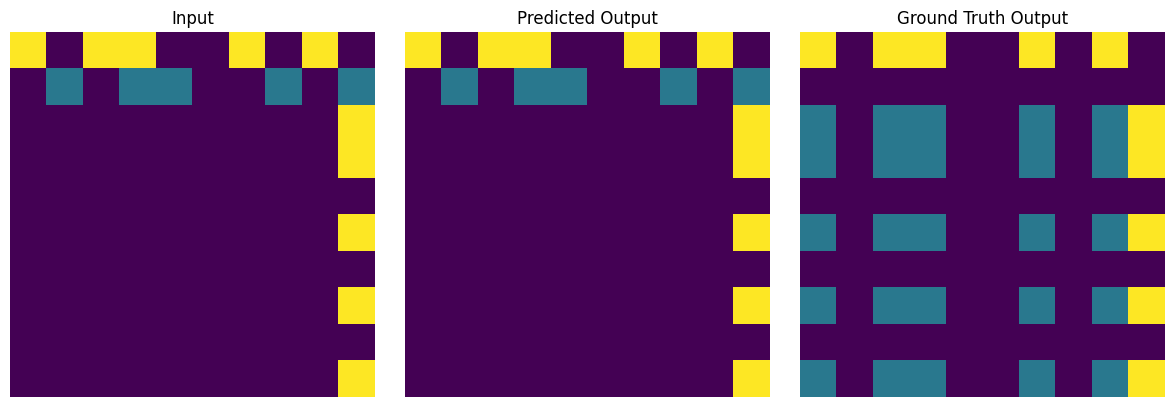

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------- helper --------------------
def safe_transform(grid):
    """
    Wraps the user‑defined `transform` so notebook cells never error out.

    If `transform` raises *any* exception, the error is caught,
    a message is printed, and a zero‑filled array of identical
    shape and dtype is returned instead.
    """
    try:
        return transform(grid)
    except Exception as err:
        print(f"[safe_transform] transform() failed – {err}")
        return np.zeros_like(grid)

# -------------------- test case -----------------
test_case = {
    "input": np.array([  # convert to np.array for convenience
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
    ]),
    "output": np.array([
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5]
    ])
}

# -------------------- run & plot ----------------
predicted_output = safe_transform(test_case["input"])

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
titles = ["Input", "Predicted Output", "Ground Truth Output"]
grids  = [test_case["input"], predicted_output, test_case["output"]]

for ax, grid, title in zip(axs, grids, titles):
    im = ax.imshow(grid, cmap="viridis", vmin=0, vmax=5)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [42]:
stop

NameError: name 'stop' is not defined

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
# !pip show transformers

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

You can use this also to load a checkpoint!!! i.e. an intermediate checkpoint from training, so you can then push it to hub.

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        # max_seq_length = 30000,
        load_in_4bit = False,
    )

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
from huggingface_hub import HfFolder, login

# Call this at the top of your script / notebook
if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
    login()                        # interactive prompt

In [ ]:
# print(model)

In [ ]:
# run_name = "Qwen2.5-Coder-7B-Instruct-gemini_synth_50_random_split_1_training-20250723-113848"
print(f"Pushing to Trelis/{run_name}")

In [ ]:
model = model.merge_and_unload()
model.push_to_hub(f"Trelis/{run_name}")
tokenizer.push_to_hub(f"Trelis/{run_name}")

In [ ]:
# # Merge to 16bit
# if False:
#     model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
# if True: # Pushing to HF Hub
#     model.push_to_hub_merged(f"Trelis/{run_name}", tokenizer, save_method = "merged_16bit")

# # Merge to 4bit
# if False:
#     model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
# if False: # Pushing to HF Hub
#     model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# # Just LoRA adapters
# if False:
#     model.save_pretrained("model")
#     tokenizer.save_pretrained("model")
# if False: # Pushing to HF Hub
#     model.push_to_hub("hf/model", token = "")
#     tokenizer.push_to_hub("hf/model", token = "")


In [ ]:
# print(tokenizer.chat_template)

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False:
    model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False:
    model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
